## Autoencoder on Fashion Mnist 

In [1]:
# 注意:魔法命令的注释不要放在同一行
%load_ext autoreload
# 当修改了模块,自动重新加载新加载
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras.backend as K  # 可以直接调用keras后台的各种张量操作
from tensorflow.keras import callbacks, datasets, layers, models
import tensorflow as tf

In [3]:
import sys

sys.path.append("../..")  # 将上两级相对路径加入系统路径
from utils import display

## CONSTANT

In [4]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS=5

## 1 Prepare Dataset

In [5]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()
# x_train.shape--(60000, 28, 28)  x_test.shape--(10000, 28, 28)

In [6]:
# Normalize to 0~1 and reshape from (None,28,28) to (None,32,32,1) with pad=0


def preprocess(imgs):
    if imgs.ndim == 3:  # 防止cell只能运行一次:因每次cell运行会增加维度等
        imgs = imgs.astype("float32") / 255.0
        imgs = np.pad(
            imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0
        )  # 0.0 means white
        imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

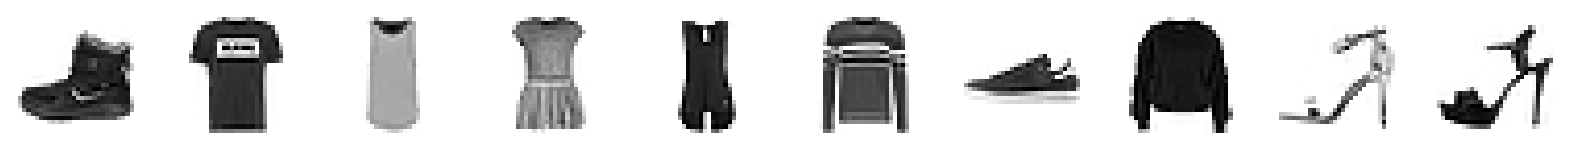

In [7]:
display(x_train)

## 2 , Build Autoencoder

In [8]:
# encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
# TensorShape([None, 32, 32, 1])
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
# [None,16,16,32] 参数:320
x = layers.Conv2D(64, (3, 3), strides=2, padding="same", activation="relu")(x)
# [None,8,8,64] 参数:64x(3x3x32+1)=18496 共64个filter,每个filter形成一个通道,每个filter配一个bias,
x = layers.Conv2D(128, (3, 3), strides=2, padding="same", activation="relu")(x)
# [None,4,4,128]参数: 128x(3x3x64+1)=73856

shape_before_flattening = K.int_shape(x)[1:]  # decoder要用
# (4,4,128)

x = layers.Flatten()(x)
encoder_output = layers.Dense(EMBEDDING_DIM, name="encoder_output")(x)

encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96770 (378.01 KB)
Trainable params: 96770 (378.

In [9]:
# decoder
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")  # (None,2)
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)  
# 4x4x128=2048 参数: (2+1)x2048=6144
x = layers.Reshape(shape_before_flattening)(x)  # TensorShape([None, 4, 4, 128])
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
# strides=2 :像素间补0 shape=(None,8,8,128) 参数:(3x3x128+1)x128=147584
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
# shape=(None,16,16,64) 参数: (3x3x128+1)x64=73792
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
# shape=(None,32,32,32) 参数: (3x3x64+1)x32=18464
decoder_output = layers.Conv2D(
    CHANNELS,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)
# shape=(None,32,32,1) 参数:3x3x32+1=289
decoder=models.Model(decoder_input,decoder_output)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 32)        1846

In [10]:
# Autoencoder
autoencoder=models.Model(encoder_input,decoder(encoder_output))
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
 model_1 (Functional)        (None, 32, 32, 1)         2462

## 3, Train the Autoencoder model

In [11]:
# compile
autoencoder.compile(optimizer='adam',loss='binary_crossentropy')

# create a model checkpoint,用于在训练过程中保存模型权重
model_checkpoint_callback=callbacks.ModelCheckpoint(
    filepath='./checkpoint',
    save_weights_only=False,  #保存权重及模型架构
    save_freq='epoch',
    monitor='loss', #监控loss值,据此确定何时保存最佳模型
    mode='min',
    save_best_only=True,
    verbose=0, #过程中无文字提示
)
tensorboard_callback=callbacks.TensorBoard(log_dir='./logs')

In [12]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test,x_test),
    callbacks=[model_checkpoint_callback,tensorboard_callback],    
)

Epoch 1/5
600/600 [==============================] - ETA: 0s - loss: 0.2941INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


600/600 [==============================] - 30s 50ms/step - loss: 0.2941 - val_loss: 0.2614
Epoch 2/5
599/600 [============================>.] - ETA: 0s - loss: 0.2578INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


600/600 [==============================] - 31s 52ms/step - loss: 0.2578 - val_loss: 0.2576
Epoch 3/5
600/600 [==============================] - ETA: 0s - loss: 0.2547INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


600/600 [==============================] - 31s 52ms/step - loss: 0.2547 - val_loss: 0.2551
Epoch 4/5
599/600 [============================>.] - ETA: 0s - loss: 0.2526INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


600/600 [==============================] - 31s 52ms/step - loss: 0.2526 - val_loss: 0.2532
Epoch 5/5
600/600 [==============================] - ETA: 0s - loss: 0.2511INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


600/600 [==============================] - 31s 52ms/step - loss: 0.2511 - val_loss: 0.2525


In [13]:
import os
print(os.getcwd())

/Users/leiou/Documents/foster/GDL2E/notebooks/03_vae/01_autoencoder


## 4,Applying autoencoder to reconstruct

In [14]:
n_to_predict=5000  #length of x_test is 10000
example_imgs=x_test[:n_to_predict]
example_labels=y_test[:n_to_predict]
predictions=autoencoder.predict(example_imgs)
predictions.shape

157/157 [==============================] - 1s 7ms/step


(5000, 32, 32, 1)

Example of real 


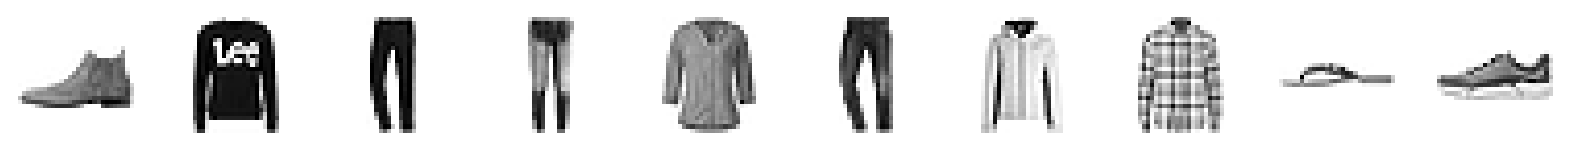

reconstruct


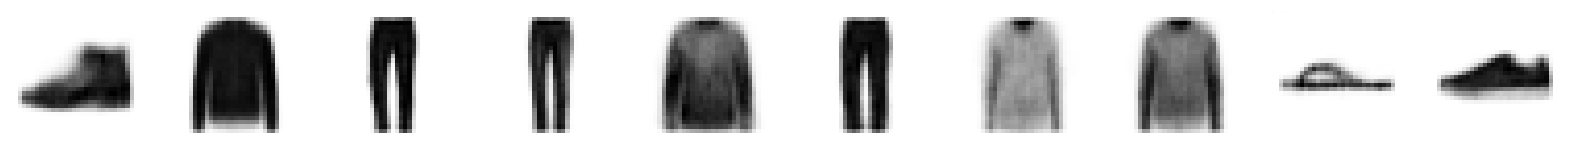

(5000, 32, 32, 1)

In [15]:

print('Example of real ')
display(example_imgs)
print('reconstruct')
display(predictions)
predictions.shape

## 5,Embed using encoder

In [16]:
#encoder eexample_imgs
embeddings=encoder.predict(example_imgs)

157/157 [==============================] - 0s 2ms/step


In [17]:
print(embeddings[100:110])  #前10个latent space

[[ 1.7962675  -1.1401025 ]
 [-0.34638652 -3.997557  ]
 [-2.7427619   1.8393656 ]
 [ 0.28897792 -3.858192  ]
 [-4.1017966   1.7539418 ]
 [-4.859482   -1.021467  ]
 [-2.310659    3.7731655 ]
 [-2.4819129   0.28641903]
 [-1.6785743  -0.9091155 ]
 [-0.45698735 -4.4090295 ]]


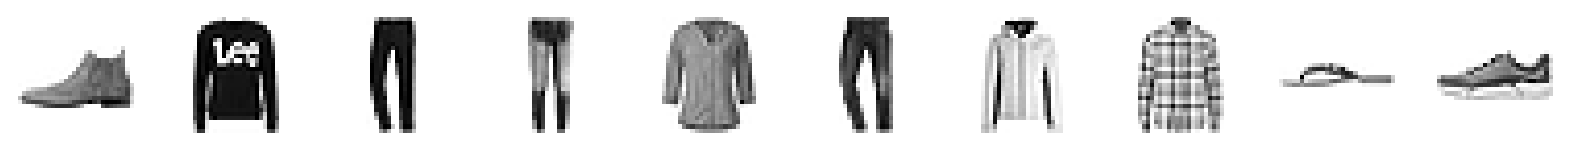

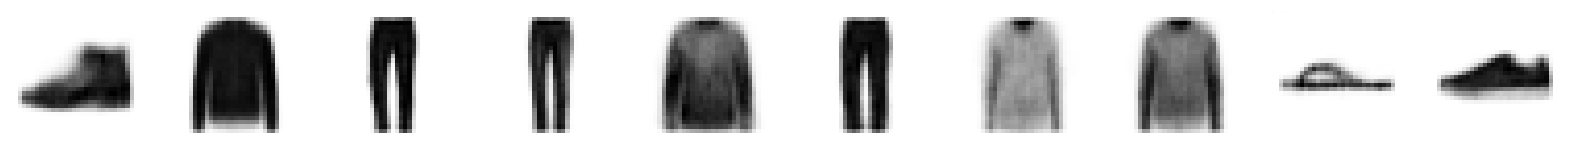

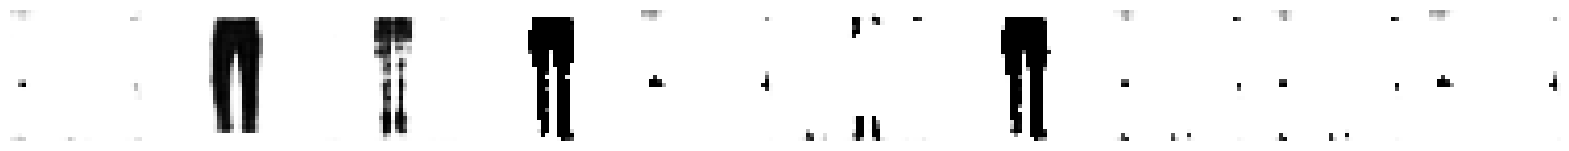

In [18]:
display(example_imgs[:10])
display(predictions[:10])
noise = tf.random.normal(shape=(10,2)) 
noise=noise.numpy()
pre=decoder(embeddings[:10]+np.abs(noise)*40)
pre=pre.numpy()
display(pre)

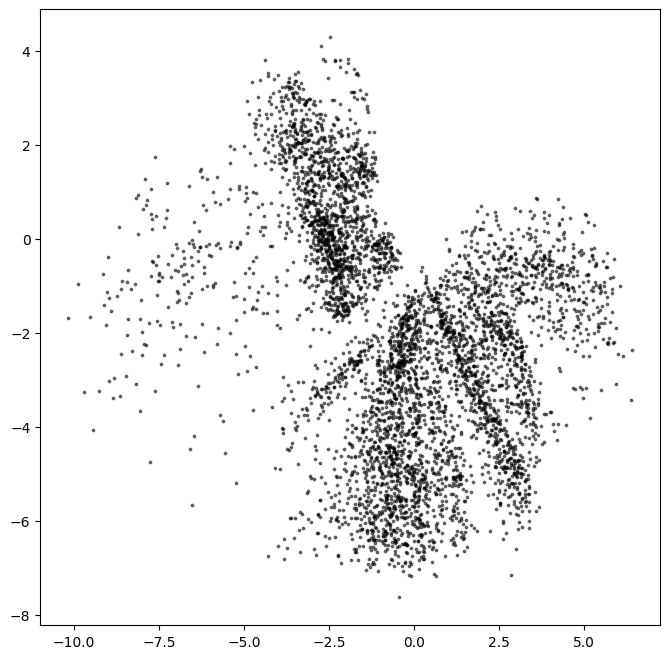

In [19]:
figsize=8
plt.figure(figsize=(figsize,figsize))
plt.scatter(embeddings[:,0],embeddings[:,1],c='black',alpha=0.5,s=3)
plt.show()

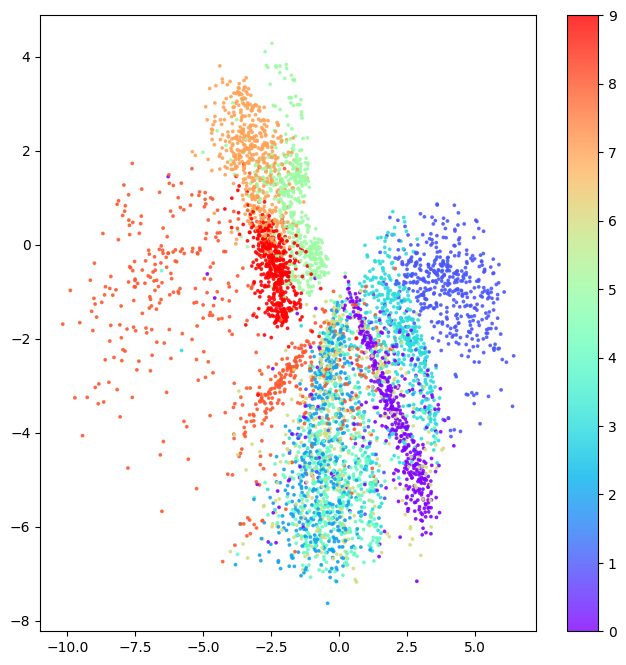

In [20]:
example_labels = y_test[:n_to_predict]
figsize=8
plt.figure(figsize=(figsize,figsize)) #画布8x8英寸
plt.scatter(
    embeddings[:,0],
    embeddings[:,1], 
    cmap='rainbow', 
    c=example_labels, #每个点的颜色由`example_labels`变量决定
    alpha=0.8,
    s=3 #点的面积为3
    
)
plt.colorbar() #example_labels变量提供的数值与颜色相对应,画颜色条
plt.show()

## 6 Generate using the decoder

In [24]:
# 得到隐空间的分布区间
mins=np.min(embeddings,axis=0)  #mins.shape=(2,)
maxs=np.max(embeddings,axis=0)  #maxs.shape=(2,)

#在latent space随机取样
grid_width,grid_height=(6,3)
samples=np.random.uniform(mins,maxs,size=(grid_width*grid_height,EMBEDDING_DIM))
# samples.shape=(18,2) 
samples.shape

(18, 2)

1/1 [==============================] - 0s 45ms/step


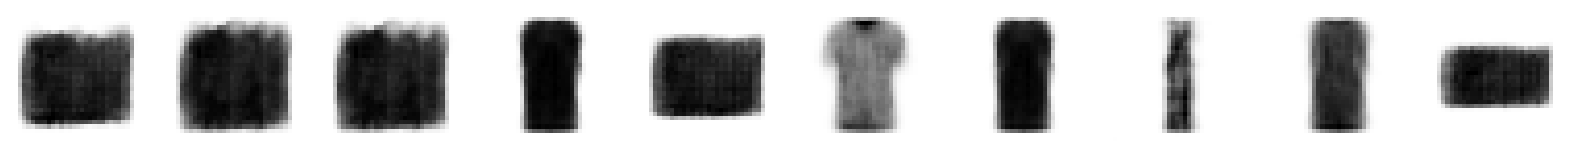

In [26]:
# Decode the samples to reconstructions
reconstructions=decoder.predict(samples)
display(reconstructions)

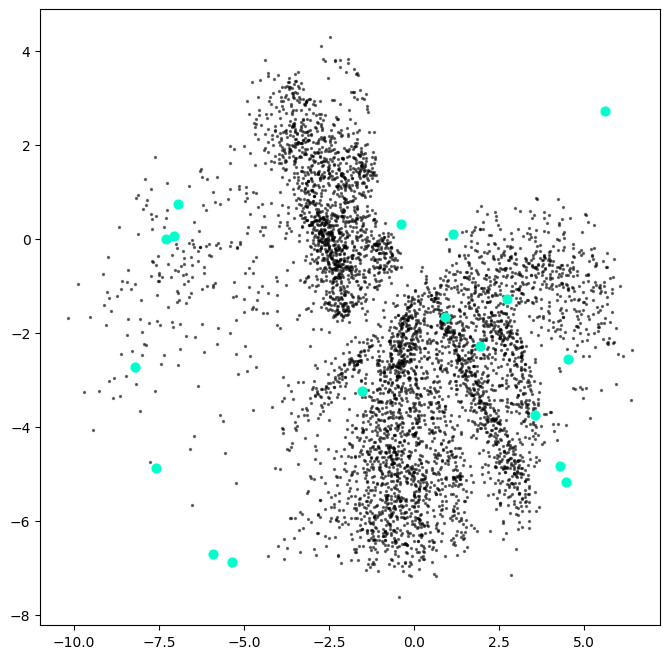

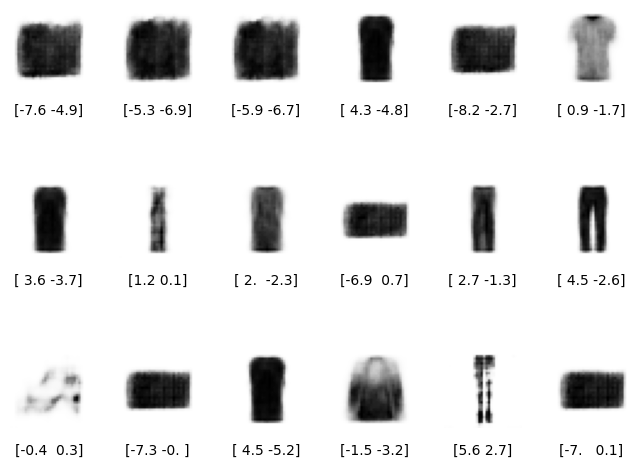

In [37]:
# draw a plot of
figsize=8
plt.figure(figsize=(figsize,figsize))

# the original embeddings
plt.scatter(embeddings[:,0],embeddings[:,1],c='black',alpha=0.5,s=2)
# the samples in laten space
plt.scatter(samples[:,0],samples[:,1],c="#00ffcc",alpha=1,s=40)

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2)) #新画布8*6英寸
fig.subplots_adjust(hspace=0.4, wspace=0.4)  #调整子图间距

for i in range(grid_width * grid_height): #0~17
    ax = fig.add_subplot(grid_height, grid_width, i + 1) #在6*3格的i+1号位置添加子图
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(samples[i], 1)),  # == str(np.round(sample[i, :], 1))
        #取四舍五入一位小数后,转为字符串
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i], cmap="Greys")  #==   ax.imshow(reconstructions[i, :, :], cmap="Greys")

8/8 [==============================] - 0s 6ms/step


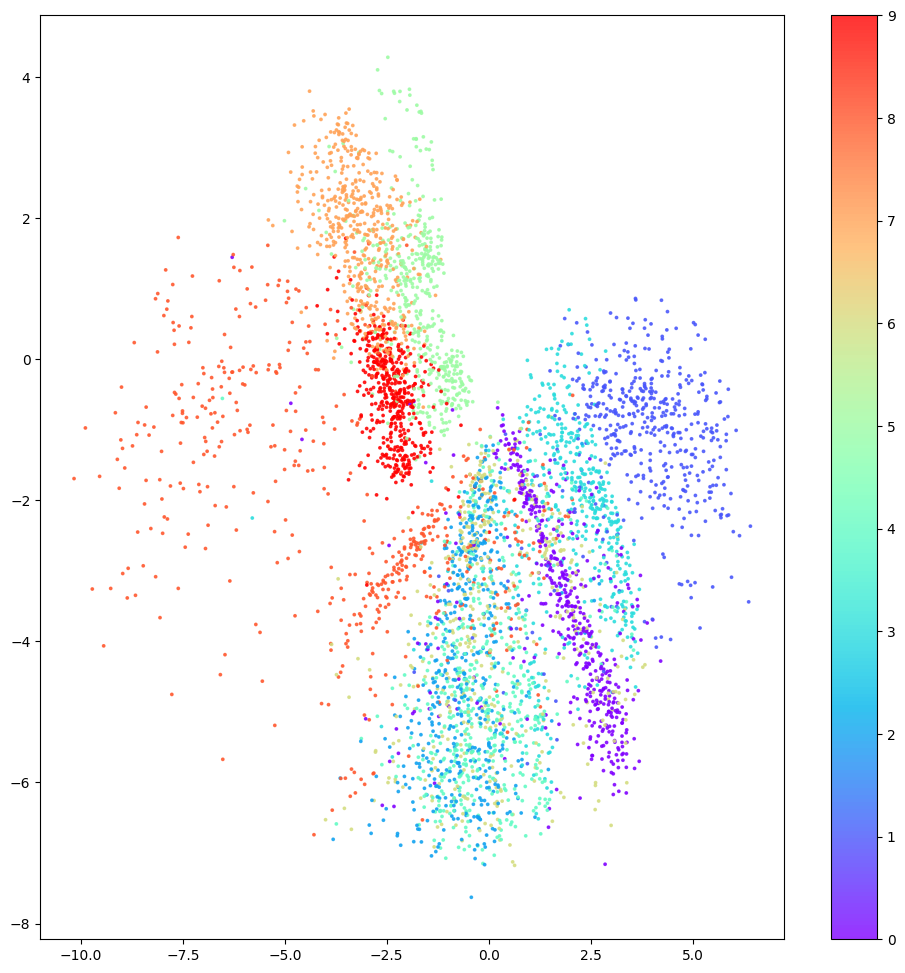

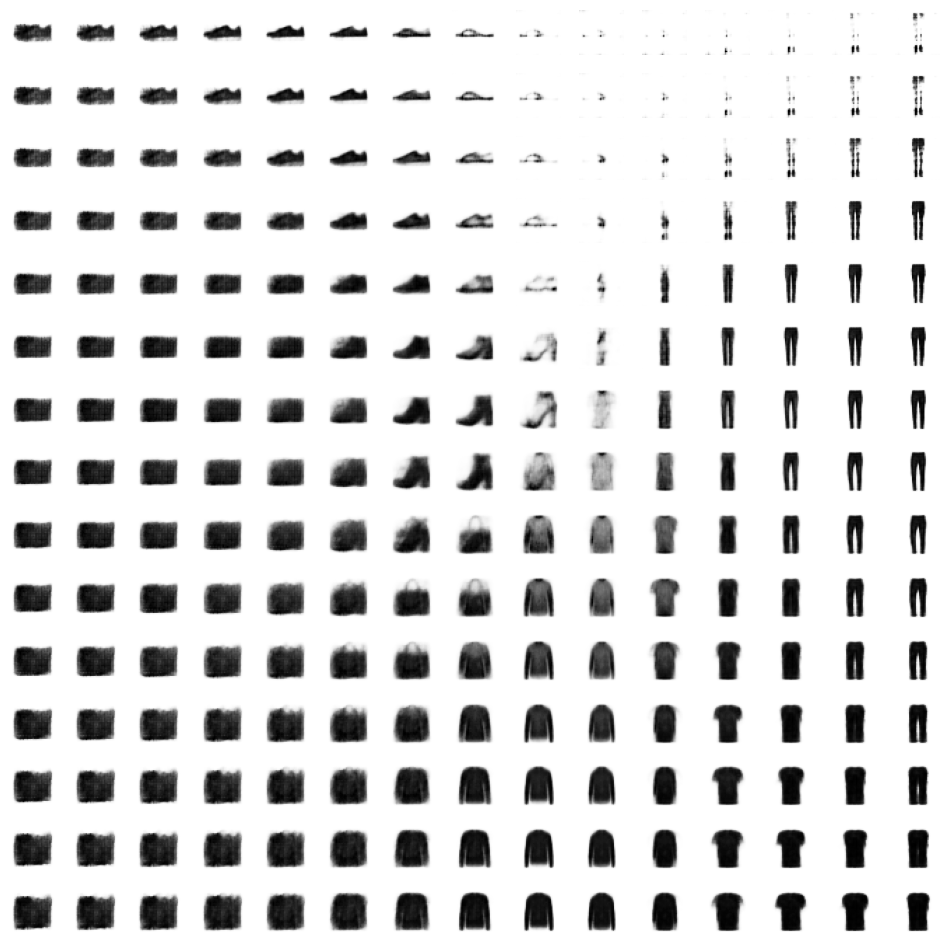

In [41]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()

x = np.linspace(np.min(embeddings[:, 0]), np.max(embeddings[:, 0]), grid_size)
#在min~max范围内,等间距取15个数
y = np.linspace(np.max(embeddings[:, 1]), np.min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")